# Deep Learning for Malaria Diagnosis
This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018) and (Jason Brownlee, 2019). Acknowledge to NIH and Bangalor Hospital who make available this malaria dataset.

Malaria is an infectuous disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes.

The Malaria burden with some key figures:
<font color='red'>
* More than 219 million cases
* Over 430 000 deaths in 2017 (Mostly: children & pregnants)
* 80% in 15 countries of Africa & India
  </font>

![MalariaBurd](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaBurden.png?raw=1)

The malaria diagnosis is performed using blood test:
* Collect patient blood smear
* Microscopic visualisation of the parasit

![MalariaDiag](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaDiag.png?raw=1)
  
Main issues related to traditional diagnosis:
<font color='#ed7d31'>
* resource-constrained regions
* time needed and delays
* diagnosis accuracy and cost
</font>

The objective of this notebook is to apply modern deep learning techniques to perform medical image analysis for malaria diagnosis.

In [1]:

import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing import image

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


In [2]:
# Configuration parameters
IMG_HEIGHT, IMG_WIDTH = 128, 128
BATCH_SIZE = 32
EPOCHS = 20
SEED = 42

# MobileNet experiment epochs (fast but decent)
EPOCHS_MOBILENET_FE = 6   # feature extraction
EPOCHS_MOBILENET_FT = 8   # fine-tuning

# Data paths
ai_project = '.'
cell_images_dir = os.path.join(ai_project, 'cell_images')
training_path = os.path.join(ai_project, 'train')
validation_path = os.path.join(ai_project, 'validation')
testing_path = os.path.join(ai_project, 'test')

print(f"Image size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Training epochs: {EPOCHS}")
print(f"MobileNet epochs (FE/FT): {EPOCHS_MOBILENET_FE}/{EPOCHS_MOBILENET_FT}")
print(f"Data directory: {cell_images_dir}")

Image size: 128x128
Batch size: 32
Training epochs: 20
MobileNet epochs (FE/FT): 6/8
Data directory: .\cell_images


## Dataset Download

We'll download the malaria cell images dataset from Kaggle.

In [3]:
# Dataset download configuration
downloadData = True
indrive = False  # Set to True if running on Google Drive

if downloadData:
    print("Downloading malaria cell images dataset...")

    if indrive:
        # For Google Drive storage (Colab)
        !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip -P "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
        !unzip "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/cell_images.zip" -d "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/"
        !ls "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
    else:
        # For local or cloud server
        !rm -rf cell_images.*  # Clean up any existing files
        !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
        !unzip cell_images.zip >/dev/null 2>&1
        !ls

        # Verify the download
        if os.path.exists(cell_images_dir):
            parasitized_count = len(os.listdir(os.path.join(cell_images_dir, 'Parasitized')))
            uninfected_count = len(os.listdir(os.path.join(cell_images_dir, 'Uninfected')))
            print(f"Dataset downloaded successfully!")
            print(f"- Parasitized: {parasitized_count:,} images")
            print(f"- Uninfected: {uninfected_count:,} images")
            print(f"- Total: {parasitized_count + uninfected_count:,} images")
        else:
            print("Download verification failed. Please check the download.")

else:
    print("Dataset download skipped (downloadData=False)")
    if os.path.exists(cell_images_dir):
        print("Using existing dataset")
    else:
        print("Warning: No dataset found. Please set downloadData=True or download manually.")

'rm' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
The system cannot find the path specified.


Download verification failed. Please check the download.


'ls' is not recognized as an internal or external command,
operable program or batch file.


## Data Preparation

We need to prepare our malaria cell image dataset for training both models.

In [4]:
# Data preparation and splitting
def create_directories():
    for path in [training_path, validation_path, testing_path]:
        if not os.path.exists(path):
            os.makedirs(os.path.join(path, 'Parasitized'))
            os.makedirs(os.path.join(path, 'Uninfected'))
    print("Data directories created successfully!")

def split_data():
    random.seed(42)  # For reproducible results

    for class_name in ['Parasitized', 'Uninfected']:
        class_dir = os.path.join(cell_images_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: {class_dir} not found. Please ensure the dataset is downloaded.")
            continue

        images = [f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(images)

        # Calculate split indices
        train_split = int(0.6 * len(images))
        val_split = int(0.8 * len(images))

        print(f"{class_name}: {len(images)} total images")

        # Copy images to respective directories
        for i, img in enumerate(images):
            src = os.path.join(class_dir, img)

            if i < train_split:
                dst = os.path.join(training_path, class_name, img)
            elif i < val_split:
                dst = os.path.join(validation_path, class_name, img)
            else:
                dst = os.path.join(testing_path, class_name, img)

            if not os.path.exists(dst):
                os.makedirs(os.path.dirname(dst), exist_ok=True)
                shutil.copy2(src, dst)

# Check if data split is needed
parasitized_train_path = os.path.join(training_path, 'Parasitized')
data_split_needed = not (os.path.exists(parasitized_train_path) and len(os.listdir(parasitized_train_path)) > 0)

if data_split_needed:
    create_directories()
    split_data()
    print("Data split completed!")
else:
    print("Data already prepared!")

# Count images in each split (with error handling)
try:
    train_parasitized = len(os.listdir(os.path.join(training_path, 'Parasitized')))
    train_uninfected = len(os.listdir(os.path.join(training_path, 'Uninfected')))
    val_parasitized = len(os.listdir(os.path.join(validation_path, 'Parasitized')))
    val_uninfected = len(os.listdir(os.path.join(validation_path, 'Uninfected')))
    test_parasitized = len(os.listdir(os.path.join(testing_path, 'Parasitized')))
    test_uninfected = len(os.listdir(os.path.join(testing_path, 'Uninfected')))

    print(f"\nData split summary:")
    print(f"Training: {train_parasitized + train_uninfected} images")
    print(f"Validation: {val_parasitized + val_uninfected} images")
    print(f"Testing: {test_parasitized + test_uninfected} images")
except FileNotFoundError as e:
    print(f"Error counting images: {e}")
    print("Please ensure the malaria dataset is downloaded and extracted to 'cell_images' directory")
    print("Expected structure:")
    print("  cell_images/")
    print("    Parasitized/")
    print("    Uninfected/")

Data directories created successfully!
Data split completed!

Data split summary:
Training: 0 images
Validation: 0 images
Testing: 0 images


## Data Generators Setup

We'll create data generators with augmentation for training and without augmentation for validation and testing.

In [5]:
# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

# No augmentation for validation and test data
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Binary classification
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    validation_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    testing_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Class indices: {train_generator.class_indices}")

Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Training samples: 0
Validation samples: 0
Test samples: 0
Class indices: {'Parasitized': 0, 'Uninfected': 1}


# MobileNet Transfer Learning

Building and training MobileNetV2 with transfer learning for malaria diagnosis.

In [6]:
# Build MobileNetV2 model for transfer learning
def create_mobilenet_model():
    # Load pre-trained MobileNetV2 (without top classifier)
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )

    # Freeze the base model
    base_model.trainable = False

    # Add custom classifier
    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create MobileNet model
mobilenet_model = create_mobilenet_model()
mobilenet_model.summary()

print("\\nMobileNetV2 model created successfully!")
print(f"Total parameters: {mobilenet_model.count_params():,}")

# Count trainable parameters
trainable_params = sum([tf.keras.backend.count_params(w) for w in mobilenet_model.trainable_weights])
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {mobilenet_model.count_params() - trainable_params:,}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

\nMobileNetV2 model created successfully!
Total parameters: 2,422,081
Trainable parameters: 164,097
Non-trainable parameters: 2,257,984


In [7]:
# Helper functions for evaluation and visualization
def plot_learning_curves(history, title, epochs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], 'b-', label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy')
    ax1.set_title(f'{title} - Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], 'b-', label='Training Loss')
    ax2.plot(history.history['val_loss'], 'r-', label='Validation Loss')
    ax2.set_title(f'{title} - Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_generator, model_name):
    # Get predictions
    test_generator.reset()
    predictions = model.predict(test_generator, verbose=0)
    y_pred = (predictions > 0.5).astype(int).flatten()
    y_true = test_generator.classes

    # Calculate metrics for binary classification
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary', zero_division=0)
    recall = recall_score(y_true, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, predictions.flatten())
    roc_auc = auc(fpr, tpr)

    # Print results
    print(f"{model_name} Results:")
    print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_true': y_true,
        'y_pred': y_pred,
        'predictions': predictions,
        'fpr': fpr,
        'tpr': tpr
    }

In [8]:
def create_directories():
    if not os.path.exists(training_path):
        os.makedirs(os.path.join(training_path, 'Infected'))
        os.makedirs(os.path.join(training_path, 'Uninfected'))
        print("Training directories created!")

    if not os.path.exists(validation_path):
        os.makedirs(os.path.join(validation_path, 'Infected'))
        os.makedirs(os.path.join(validation_path, 'Uninfected'))
        print("Validation directories created!")

    if not os.path.exists(testing_path):
        os.makedirs(os.path.join(testing_path, 'Infected'))
        os.makedirs(os.path.join(testing_path, 'Uninfected'))
        print("Testing directories created!")

create_directories()

data splitting function

In [9]:
def split_data_60_20_20():
    # Find where our images are stored
    infected_dir = os.path.join(cell_images_dir, 'Parasitized')
    uninfected_dir = os.path.join(cell_images_dir, 'Uninfected')

    print(f"Looking for data in:")
    print(f"Infected: {infected_dir}")
    print(f"Uninfected: {uninfected_dir}")

    # Get all image files (only png, jpg, jpeg formats)
    infected_images = [f for f in os.listdir(infected_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    uninfected_images = [f for f in os.listdir(uninfected_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    print(f"Found {len(infected_images)} infected images")
    print(f"Found {len(uninfected_images)} uninfected images")

    # Mix up the order randomly (but always the same way with seed=42)
    random.seed(42)  # Makes results reproducible
    random.shuffle(infected_images)
    random.shuffle(uninfected_images)

    # Figure out how to split images: 60% train, 20% validation, 20% test
    def get_splits(total_images):
        train_split = int(0.6 * total_images)
        val_split = int(0.8 * total_images)  # 60% + 20% = 80%
        return train_split, val_split

    infected_train_split, infected_val_split = get_splits(len(infected_images))
    uninfected_train_split, uninfected_val_split = get_splits(len(uninfected_images))

    # Split infected images into train/validation/test
    for i, img in enumerate(infected_images):
        src = os.path.join(infected_dir, img)

        if i < infected_train_split:  # First 60%
            dst = os.path.join(training_path, 'Infected', img)
        elif i < infected_val_split:  # Next 20% (60%-80%)
            dst = os.path.join(validation_path, 'Infected', img)
        else:  # Last 20% (80%-100%)
            dst = os.path.join(testing_path, 'Infected', img)

        if not os.path.exists(dst):
            shutil.copy2(src, dst)

    for i, img in enumerate(uninfected_images):
        src = os.path.join(uninfected_dir, img)

        if i < uninfected_train_split:  # First 60%
            dst = os.path.join(training_path, 'Uninfected', img)
        elif i < uninfected_val_split:  # Next 20% (60%-80%)
            dst = os.path.join(validation_path, 'Uninfected', img)
        else:  # Last 20% (80%-100%)
            dst = os.path.join(testing_path, 'Uninfected', img)

        if not os.path.exists(dst):
            shutil.copy2(src, dst)

    # Calculate and display split statistics
    infected_train_count = infected_train_split
    infected_val_count = infected_val_split - infected_train_split
    infected_test_count = len(infected_images) - infected_val_split

    uninfected_train_count = uninfected_train_split
    uninfected_val_count = uninfected_val_split - uninfected_train_split
    uninfected_test_count = len(uninfected_images) - uninfected_val_split

    print(f"\n=== 60/20/20 Data Split Completed ===")
    print(f"Training (60%) - Infected: {infected_train_count}, Uninfected: {uninfected_train_count}")
    print(f"Validation (20%) - Infected: {infected_val_count}, Uninfected: {uninfected_val_count}")
    print(f"Testing (20%) - Infected: {infected_test_count}, Uninfected: {uninfected_test_count}")
    print(f"\nTotal images: {len(infected_images) + len(uninfected_images)}")

# Run data splitting
split_data_60_20_20()

def prepare_602020_split(source_dir, target_dir):
    print(f"Preparing MobileNet data split from {source_dir} to {target_dir}")

    # Define source directories (original dataset structure)
    parasitized_dir = os.path.join(source_dir, 'Parasitized')
    uninfected_dir = os.path.join(source_dir, 'Uninfected')

    # Define target directories
    train_dir = os.path.join(target_dir, 'train')
    val_dir = os.path.join(target_dir, 'val')
    test_dir = os.path.join(target_dir, 'test')

    # Create target directories
    for split in ['train', 'val', 'test']:
        for class_name in ['Parasitized', 'Uninfected']:
            path = os.path.join(target_dir, split, class_name)
            if not os.path.exists(path):
                os.makedirs(path)

    # Process each class
    for class_name, src_dir in [('Parasitized', parasitized_dir), ('Uninfected', uninfected_dir)]:
        if not os.path.exists(src_dir):
            print(f"Warning: {src_dir} not found, skipping...")
            continue

        images = [f for f in os.listdir(src_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        random.seed(42)  # For reproducibility
        random.shuffle(images)

        total = len(images)
        train_end = int(0.6 * total)
        val_end = int(0.8 * total)

        splits = [
            ('train', images[:train_end]),
            ('val', images[train_end:val_end]),
            ('test', images[val_end:])
        ]

        for split_name, split_images in splits:
            for img in split_images:
                src = os.path.join(src_dir, img)
                dst = os.path.join(target_dir, split_name, class_name, img)
                if not os.path.exists(dst):
                    shutil.copy2(src, dst)

        print(f"{class_name}: train={len(splits[0][1])}, val={len(splits[1][1])}, test={len(splits[2][1])}")

    print("MobileNet 60/20/20 split completed!")


Looking for data in:
Infected: .\cell_images\Parasitized
Uninfected: .\cell_images\Uninfected


FileNotFoundError: [WinError 3] The system cannot find the path specified: '.\\cell_images\\Parasitized'

data generators

In [ ]:

train_datagen = ImageDataGenerator(
    rescale=1./255,           # Make pixel values between 0 and 1
    rotation_range=10,        # Randomly rotate images a little
    width_shift_range=0.1,    # Randomly move images left/right
    height_shift_range=0.1,   # Randomly move images up/down
    horizontal_flip=True,     # Sometimes flip images like a mirror
    zoom_range=0.1           # Randomly zoom in/out a little
)

val_test_datagen = ImageDataGenerator(rescale=1./255)  # Only make pixels 0 to 1

# Create generators for train, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=['Infected', 'Uninfected']
)

validation_generator = val_test_datagen.flow_from_directory(
    validation_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=['Infected', 'Uninfected']
)

test_generator = val_test_datagen.flow_from_directory(
    testing_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=['Infected', 'Uninfected']
)

print("=== 60/20/20 Data Generators Created Successfully ===")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Testing samples: {test_generator.samples}")
print(f"Total samples: {train_generator.samples + validation_generator.samples + test_generator.samples}")

Found 25346 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.
Found 9914 images belonging to 2 classes.
Found 9914 images belonging to 2 classes.
=== 60/20/20 Data Generators Created Successfully ===
Training samples: 25346
Validation samples: 5512
Testing samples: 9914
Total samples: 40772
=== 60/20/20 Data Generators Created Successfully ===
Training samples: 25346
Validation samples: 5512
Testing samples: 9914
Total samples: 40772


## MobileNetV2 Transfer Learning

This section provides a compact MobileNetV2 transfer-learning pipeline. It uses a 60/20/20 split, trains for 5 epochs, reports metrics as percentages, and displays comprehensive plots.

In [ ]:
print(f"MobileNet experiments configured: FE={EPOCHS_MOBILENET_FE} epochs, FT={EPOCHS_MOBILENET_FT} epochs")

# Paths for MobileNet data
dataset_dir = os.path.join('.', 'cell_images')
mobilenet_base_dir = os.path.join('.', 'mobilenet_data')
train_dir = os.path.join(mobilenet_base_dir, 'train')
val_dir = os.path.join(mobilenet_base_dir, 'val')
test_dir = os.path.join(mobilenet_base_dir, 'test')

# Ensure a 60/20/20 split exists (Parasitized/Uninfected)
def _prepare_split_if_missing():
    if os.path.exists(train_dir) and os.path.exists(val_dir) and os.path.exists(test_dir):
        print("Data split already exists, using existing split.")
        return
    # Fallback: define a small inline splitter if not already defined elsewhere
    try:
        prepare_602020_split  # from earlier cell if executed
        def _runner():
            prepare_602020_split(dataset_dir, mobilenet_base_dir)
    except NameError:
        def _runner():
            os.makedirs(mobilenet_base_dir, exist_ok=True)
            classes = ['Parasitized', 'Uninfected']
            for split in ['train', 'val', 'test']:
                for c in classes:
                    os.makedirs(os.path.join(mobilenet_base_dir, split, c), exist_ok=True)
            for c in classes:
                cdir = os.path.join(dataset_dir, c)
                if not os.path.exists(cdir):
                    print(f"Warning: {cdir} not found")
                    continue
                imgs = [f for f in os.listdir(cdir) if f.lower().endswith(('.png','.jpg','.jpeg'))]
                random.seed(SEED); random.shuffle(imgs)
                n = len(imgs); a = int(0.6*n); b = int(0.8*n)
                for name, subset in [('train', imgs[:a]), ('val', imgs[a:b]), ('test', imgs[b:])]:
                    for f in subset:
                        src = os.path.join(cdir, f)
                        dst = os.path.join(mobilenet_base_dir, name, c, f)
                        if not os.path.exists(dst): shutil.copy2(src, dst)
                print(f"{c}: Train={a}, Val={b-a}, Test={n-b}")
    _runner()
    print("Data split completed successfully!")

_prepare_split_if_missing()
print("Model architecture setup ready.")

MobileNet experiments configured: FE=6 epochs, FT=8 epochs
Data split already exists, using existing split.
Model architecture setup ready.


## MobileNetV2: Two Experiments (Feature Extraction vs Fine-Tuning)
We run two fast experiments:
- Feature extraction: freeze the MobileNetV2 base and train only a small classifier head.
- Fine-tuning: unfreeze the top layers of the base and train with a smaller learning rate.
Both include callbacks, learning curves, confusion matrix, and ROC/AUC.

Explain: Utility functions to plot confusion matrix and ROC/AUC for model evaluation.

In [ ]:
# Extra evaluation helpers (confusion matrix and ROC plotting)
def plot_confusion_matrix_from_preds(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(4, 3))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def plot_roc_auc(fpr, tpr, auc_value, title='ROC Curve'):
    plt.figure(figsize=(4, 3))
    plt.plot(fpr, tpr, label=f'AUC = {auc_value:.3f}')
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

Explain: Build MobileNet-specific data generators with light augmentation for train and simple rescaling for validation/test.

In [ ]:
# MobileNet-specific generators (binary classes: Parasitized=0, Uninfected=1)
mobilenet_train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
    zoom_range=0.15, horizontal_flip=True, fill_mode='nearest'
)
mobilenet_val_datagen = ImageDataGenerator(rescale=1./255)

mobilenet_train_gen = mobilenet_train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=True, seed=SEED
)
mobilenet_val_gen = mobilenet_val_datagen.flow_from_directory(
    val_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=False
)
mobilenet_test_gen = mobilenet_val_datagen.flow_from_directory(
    test_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=False
)
print(f"Train/Val/Test: {mobilenet_train_gen.samples}/{mobilenet_val_gen.samples}/{mobilenet_test_gen.samples}")
print(f"Class indices: {mobilenet_train_gen.class_indices}")

Found 16534 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.
Train/Val/Test: 16534/5512/5512
Class indices: {'Parasitized': 0, 'Uninfected': 1}
Train/Val/Test: 16534/5512/5512
Class indices: {'Parasitized': 0, 'Uninfected': 1}


Explain: Experiment A (Feature Extraction) — freeze base, train a small classifier head with callbacks, evaluate and save.

Epoch 1/6
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 973ms/step - accuracy: 0.7927 - auc: 0.8702 - loss: 0.4358
Epoch 1: val_accuracy improved from None to 0.87046, saving model to mobilenet_fe.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 649s 1s/step - accuracy: 0.8440 - auc: 0.9220 - loss: 0.3551 - val_accuracy: 0.8705 - val_auc: 0.9656 - val_loss: 0.2884 - learning_rate: 0.0010
Epoch 2/6
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.8822 - auc: 0.9489 - loss: 0.2877
Epoch 2: val_accuracy improved from 0.87046 to 0.88570, saving model to mobilenet_fe.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 316s 612ms/step - accuracy: 0.8854 - auc: 0.9491 - loss: 0.2865 - val_accuracy: 0.8857 - val_auc: 0.9685 - val_loss: 0.2643 - learning_rate: 0.0010
Epoch 3/6
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.8917 - auc: 0.9545 - loss: 0.2711
Epoch 3: val_accuracy improved from 0.88570 to 0.90221, saving model to mobilenet_fe.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 350s 677ms/step - accuracy: 0.8909 - auc: 0.954

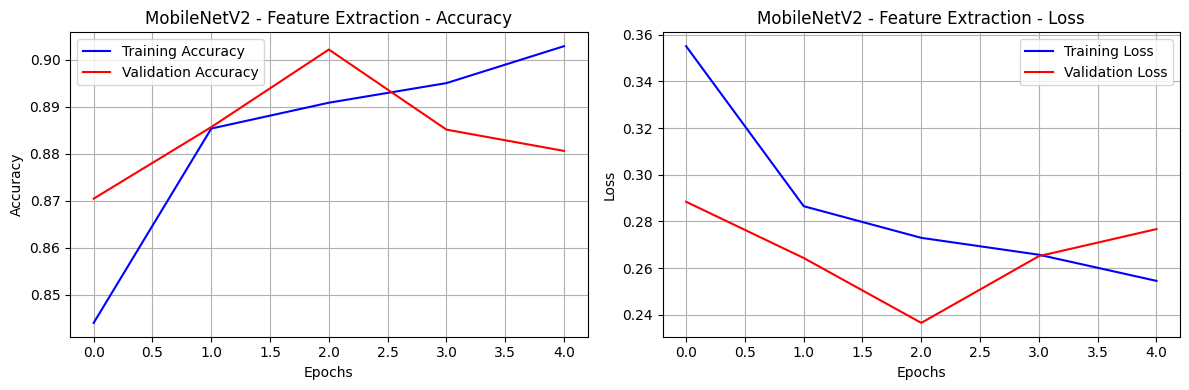

MobileNetV2 - Feature Extraction Results:
Accuracy:  0.9051 (90.51%)
Precision: 0.8681
Recall:    0.9554
F1-Score:  0.9097
ROC-AUC:   0.9703


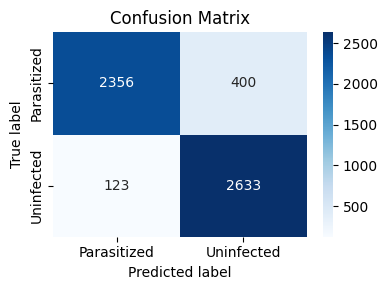

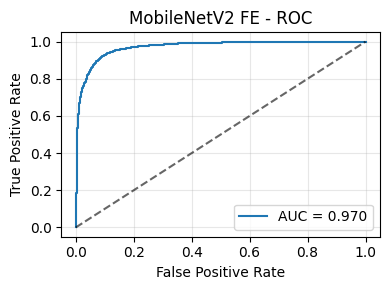

In [ ]:
# Experiment A: Feature Extraction (freeze base) — fast and stable
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False

inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.30)(x)
outputs = Dense(1, activation='sigmoid')(x)
mobilenet_fe = tf.keras.Model(inputs, outputs, name='MobileNetV2_FE')

mobilenet_fe.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

cb_fe = [
    EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6, verbose=1),
    ModelCheckpoint('mobilenet_fe.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
]

history_fe = mobilenet_fe.fit(
    mobilenet_train_gen,
    validation_data=mobilenet_val_gen,
    epochs=EPOCHS_MOBILENET_FE,
    callbacks=cb_fe,
    verbose=1,
)

plot_learning_curves(history_fe, 'MobileNetV2 - Feature Extraction', EPOCHS_MOBILENET_FE)
fe_eval = evaluate_model(mobilenet_fe, mobilenet_test_gen, 'MobileNetV2 - Feature Extraction')
plot_confusion_matrix_from_preds(fe_eval['y_true'], fe_eval['y_pred'], ['Parasitized', 'Uninfected'])
plot_roc_auc(fe_eval['fpr'], fe_eval['tpr'], fe_eval['roc_auc'], title='MobileNetV2 FE - ROC')

# Save the feature extraction model snapshot
mobilenet_fe.save('mobilenet_fe_final.keras')

# Store results for the summary table
mobilenet_runs = [{
    'Experiment': 'Feature Extraction',
    'epochs': len(history_fe.history['accuracy']),
    'accuracy': fe_eval['accuracy'],
    'precision': fe_eval['precision'],
    'recall': fe_eval['recall'],
    'f1': fe_eval['f1'],
    'roc_auc': fe_eval['roc_auc']
}]

Explain: Experiment B (Fine-Tuning) — unfreeze top layers, lower LR, train briefly with callbacks, evaluate and save.

Epoch 1/8
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.8214 - auc: 0.9400 - loss: 0.5205
Epoch 1: val_accuracy improved from None to 0.78302, saving model to mobilenet_ft.keras

Epoch 1: val_accuracy improved from None to 0.78302, saving model to mobilenet_ft.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 323s 600ms/step - accuracy: 0.8769 - auc: 0.9492 - loss: 0.3726 - val_accuracy: 0.7830 - val_auc: 0.9610 - val_loss: 0.6943 - learning_rate: 1.0000e-05
Epoch 2/8
517/517 ━━━━━━━━━━━━━━━━━━━━ 323s 600ms/step - accuracy: 0.8769 - auc: 0.9492 - loss: 0.3726 - val_accuracy: 0.7830 - val_auc: 0.9610 - val_loss: 0.6943 - learning_rate: 1.0000e-05
Epoch 2/8
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.9248 - auc: 0.9668 - loss: 0.2454
Epoch 2: val_accuracy improved from 0.78302 to 0.86956, saving model to mobilenet_ft.keras

Epoch 2: val_accuracy improved from 0.78302 to 0.86956, saving model to mobilenet_ft.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 312s 603ms/step - accuracy: 0.9233 - 

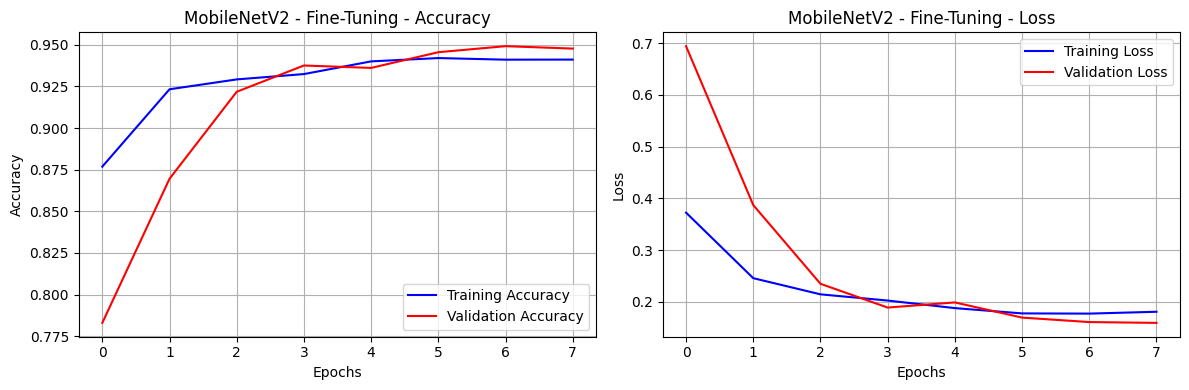

MobileNetV2 - Fine-Tuning Results:
Accuracy:  0.9496 (94.96%)
Precision: 0.9287
Recall:    0.9739
F1-Score:  0.9508
ROC-AUC:   0.9874


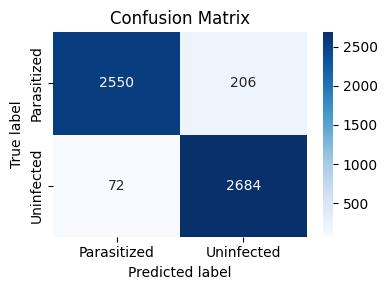

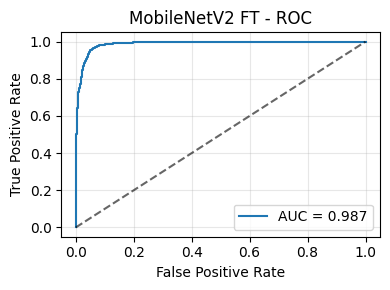

In [ ]:
UNFREEZE_LAYERS = 40  # top-N layers to fine-tune

# Unfreeze part of the base model and recompile with a smaller LR
base_model.trainable = True
for layer in base_model.layers[:-UNFREEZE_LAYERS]:
    layer.trainable = False

mobilenet_fe.compile(  # same graph, different trainable set
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

cb_ft = [
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-7, verbose=1),
    ModelCheckpoint('mobilenet_ft.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
]

history_ft = mobilenet_fe.fit(
    mobilenet_train_gen,
    validation_data=mobilenet_val_gen,
    epochs=EPOCHS_MOBILENET_FT,
    callbacks=cb_ft,
    verbose=1,
)

plot_learning_curves(history_ft, 'MobileNetV2 - Fine-Tuning', EPOCHS_MOBILENET_FT)
ft_eval = evaluate_model(mobilenet_fe, mobilenet_test_gen, 'MobileNetV2 - Fine-Tuning')
plot_confusion_matrix_from_preds(ft_eval['y_true'], ft_eval['y_pred'], ['Parasitized', 'Uninfected'])
plot_roc_auc(ft_eval['fpr'], ft_eval['tpr'], ft_eval['roc_auc'], title='MobileNetV2 FT - ROC')

# Save the fine-tuned model snapshot
mobilenet_fe.save('mobilenet_ft_final.keras')

mobilenet_runs.append({
    'Experiment': f'Fine-Tuning (top {UNFREEZE_LAYERS})',
    'epochs': len(history_ft.history['accuracy']),
    'accuracy': ft_eval['accuracy'],
    'precision': ft_eval['precision'],
    'recall': ft_eval['recall'],
    'f1': ft_eval['f1'],
    'roc_auc': ft_eval['roc_auc']
})

Explain: Build a compact results table with metrics from both experiments.

In [ ]:
# Compact results table
results_df = pd.DataFrame(mobilenet_runs)
results_df = results_df[['Experiment', 'epochs', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']]
print(results_df.to_string(index=False))

          Experiment  epochs  accuracy  precision   recall       f1  roc_auc
  Feature Extraction       5  0.905116   0.868117 0.955370 0.909656 0.970256
Fine-Tuning (top 40)       8  0.949565   0.928720 0.973875 0.950762 0.987358


Explain: Compare experiments, save a CSV of results, pick the best model (by F1 then AUC), and copy it to mobilenet_best.keras.

In [ ]:
# Compare FE vs FT, save CSV, and export the best model artifact
results_df.to_csv('mobilenet_results.csv', index=False)
cmp = results_df.sort_values(['f1', 'roc_auc', 'accuracy'], ascending=False).reset_index(drop=True)
best = cmp.iloc[0]
best_is_fe = ('Feature Extraction' in str(best['Experiment']))
best_path = 'mobilenet_fe_final.keras' if best_is_fe else 'mobilenet_ft_final.keras'
print('Best experiment:', best['Experiment'])
print(best[['accuracy','precision','recall','f1','roc_auc']].to_string())

if os.path.exists(best_path):
    shutil.copyfile(best_path, 'mobilenet_best.keras')
    print(f"Saved best model to mobilenet_best.keras from {best_path}")
else:
    print(f"Warning: expected model file not found: {best_path}")

Best experiment: Fine-Tuning (top 40)
accuracy     0.949565
precision     0.92872
recall       0.973875
f1           0.950762
roc_auc      0.987358
Saved best model to mobilenet_best.keras from mobilenet_ft_final.keras
